In [1]:
# RUN THIS LINE ONLY ONCE !!!
import sys
import os
os.chdir('../')
sys.path.append(os.getcwd())

In [3]:
from utils import get_dataset, validate
from learner import Learner
from schedulers import CyclicLRDecay
import random
import os
import torch
import torch.nn as nn
from torch.optim import AdamW

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# If you have dark theme
from matplotlib.pyplot import rcParams
rcParams['figure.facecolor'] = 'white'

In [5]:
# Setup logger
import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s : %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')

In [6]:
dataset, test_dataset, emb_weights = get_dataset(min_freq=5, test_set=True)
dataset.fields['review'].include_lengths = True

random.seed(35)
ds_train, ds_val = dataset.split(split_ratio=[0.9, 0.1])

06/11/2020 11:41:09 AM INFO : ----- IMDb dataset -----
06/11/2020 11:41:19 AM INFO : Building training dataset
06/11/2020 11:42:34 AM INFO : Building vocab
06/11/2020 11:42:34 AM INFO : Loading vectors from .vector_cache/glove.840B.300d.txt.pt
06/11/2020 11:43:30 AM INFO : Building test dataset


In [223]:
class CNN(nn.Module):
    def __init__(self, emb_weights, out_channels=100, kernel_heights=(3, 5, 7), dropout=(0, 0)):
        super().__init__()

        self.embedding = nn.Embedding.from_pretrained(emb_weights)
        convolutions = []
        emb_dim = emb_weights.shape[1]
        for kernel in kernel_heights:
            padding = (kernel - 1) // 2
            convolutions.append(nn.Conv1d(emb_dim, out_channels, kernel, padding=padding))
        self.convolutions = nn.ModuleList(convolutions)
        self.emb_dropout = nn.Dropout(p=dropout[0])
        self.relu = nn.ReLU()
        self.head = nn.Sequential(
            nn.Linear(len(kernel_heights)*out_channels, len(kernel_heights)*out_channels//2),
            nn.Dropout(p=dropout[1]),
            nn.ReLU(),
            nn.Linear(len(kernel_heights)*out_channels//2, 2)
        )

    def forward(self, batch):
        batch, lengths = batch

        embedded = self.emb_dropout(self.embedding(batch)) # B x L x E
        embedded = embedded.transpose(1, 2) # B x E x L
        max_out = [self.conv_block(embedded, self.convolutions[i]) for i in range(len(self.convolutions))]
        cat_out = torch.cat(max_out, dim=1) # B x C*K

        return self.head(cat_out)
    
    def conv_block(self, input, conv_layer):
        # think about adding masking before max
        output = conv_layer(input)
        output = self.relu(output)
        output = torch.max(output, dim=2)[0]
        return output

In [0]:
model = CNN(emb_weights.clone(), out_channels=128,
            kernel_heights=(1, 3, 5), dropout=(0.55, 0.5)).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimiser = AdamW(model.parameters(), weight_decay=1e-3)
cycle_steps = (len(ds_train)//64 + 1)
scheduler = CyclicLRDecay(optimiser, 6e-5, 3e-3, cycle_steps, 0.1, gamma_factor=0.7)
learner = Learner(model, loss_fn, optimiser, scheduler, ds_train, ds_val, device)

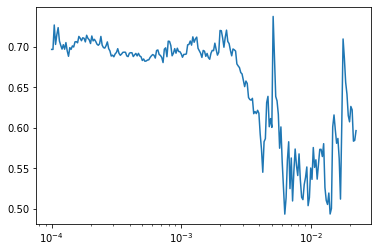

In [0]:
learner.lr_finder(bs=64, lr_range=(1e-4, 1e-1))

In [18]:
learner.train(epochs=2, bs=64, grad_clip=(0.5, 2.0))

06/11/2020 08:09:17 AM INFO : Epoch : 1, batch : 88, train_loss = 0.6847, val_loss = 0.5267, val_accuracy : 0.764, time = 4s
06/11/2020 08:09:20 AM INFO : Epoch : 1, batch : 176, train_loss = 0.4425, val_loss = 0.3713, val_accuracy : 0.840, time = 8s
06/11/2020 08:09:24 AM INFO : Epoch : 1, batch : 264, train_loss = 0.3905, val_loss = 0.3290, val_accuracy : 0.857, time = 11s
06/11/2020 08:09:28 AM INFO : Epoch : 1, batch : 352, train_loss = 0.3718, val_loss = 0.3356, val_accuracy : 0.856, time = 15s
06/11/2020 08:09:31 AM INFO : Epoch : 2, batch : 88, train_loss = 0.3690, val_loss = 0.3127, val_accuracy : 0.868, time = 19s
06/11/2020 08:09:35 AM INFO : Epoch : 2, batch : 176, train_loss = 0.3444, val_loss = 0.3483, val_accuracy : 0.855, time = 22s
06/11/2020 08:09:39 AM INFO : Epoch : 2, batch : 264, train_loss = 0.3671, val_loss = 0.3019, val_accuracy : 0.876, time = 26s
06/11/2020 08:09:42 AM INFO : Epoch : 2, batch : 352, train_loss = 0.3354, val_loss = 0.2924, val_accuracy : 0.881,

In [19]:
model.embedding.weight.requires_grad_(True);
learner.train(epochs=8, bs=64, grad_clip=(0.5, 2.0))

06/11/2020 08:09:48 AM INFO : Epoch : 1, batch : 88, train_loss = 0.3308, val_loss = 0.3147, val_accuracy : 0.868, time = 5s
06/11/2020 08:09:53 AM INFO : Epoch : 1, batch : 176, train_loss = 0.2940, val_loss = 0.2657, val_accuracy : 0.897, time = 11s
06/11/2020 08:09:59 AM INFO : Epoch : 1, batch : 264, train_loss = 0.2843, val_loss = 0.2609, val_accuracy : 0.894, time = 16s
06/11/2020 08:10:04 AM INFO : Epoch : 1, batch : 352, train_loss = 0.2910, val_loss = 0.2651, val_accuracy : 0.893, time = 22s
06/11/2020 08:10:09 AM INFO : Epoch : 2, batch : 88, train_loss = 0.2527, val_loss = 0.2590, val_accuracy : 0.900, time = 27s
06/11/2020 08:10:15 AM INFO : Epoch : 2, batch : 176, train_loss = 0.2336, val_loss = 0.2499, val_accuracy : 0.899, time = 32s
06/11/2020 08:10:20 AM INFO : Epoch : 2, batch : 264, train_loss = 0.2617, val_loss = 0.2538, val_accuracy : 0.898, time = 38s
06/11/2020 08:10:25 AM INFO : Epoch : 2, batch : 352, train_loss = 0.2448, val_loss = 0.2523, val_accuracy : 0.900

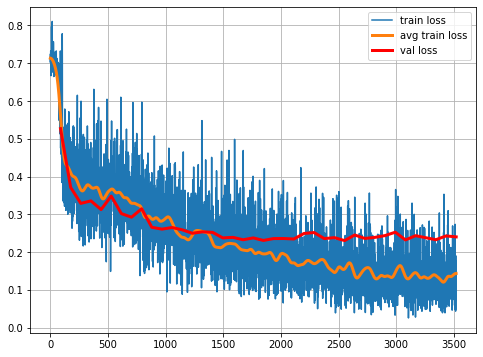

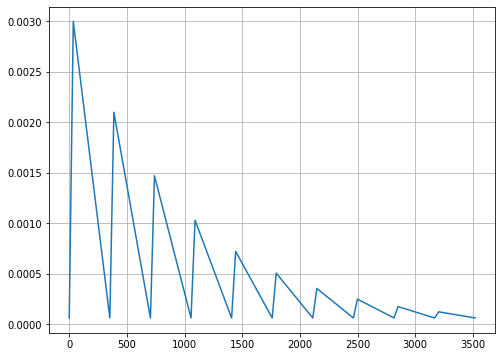

In [20]:
learner.recorder.plot_losses(show_lr=True)

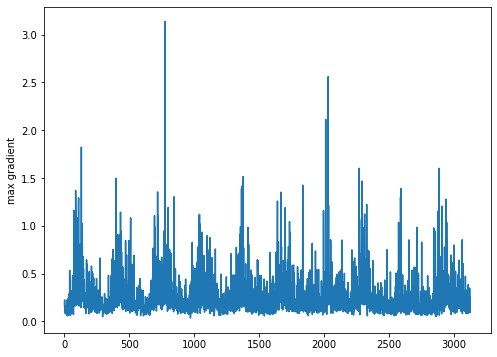

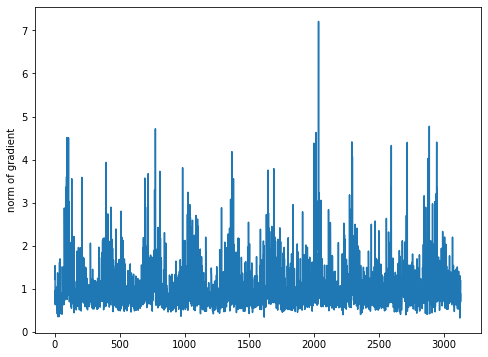

In [0]:
learner.recorder.plot_grads()

In [21]:
print('Test loss : {:.5f}, test accuracy : {:.03f}'.format(*validate(test_dataset, loss_fn, model, 64)))

Test loss : 0.26982, test accuracy : 0.897


In [ ]:
if not os.path.exists('models'):
    os.makedirs('models')
torch.save(model.state_dict(), 'models/model_CNN_shallow.pt')

In [225]:
class Hook():
    def __init__(self, module, forward=True):
        if forward:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.output = output
        self.input = input

In [226]:
from IPython.core.display import HTML

def weighted_colour(words, weights):
    text = "<h3>"
    for word, weight in zip(words, weights):
        weight = (1 - weight) * 256
        text += "<span style='background-color: rgb({}); color: black'> {} </span>".format("256,"+str(weight)+","+str(weight), word)
    text += "</h3>"
    return text

In [224]:
model = CNN(emb_weights.clone(), out_channels=128,
            kernel_heights=(1, 3, 5), dropout=(0.55, 0.5)).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
model.load_state_dict(torch.load('models/model_CNN_shallow.pt', map_location=device))

<All keys matched successfully>

In [267]:
from torchtext.data import Iterator
iterator = iter(Iterator(test_dataset, 1, shuffle=True, device=device))
model.eval();

hook_b = Hook(model.convolutions[2], forward=False)
hook_f = Hook(model.convolutions[2])

In [274]:
batch = next(iterator)

In [275]:
# Create heatmap
output = model(batch.review)
print('Label : {}'.format('positive' if batch.label.item() else 'negative'))
print('Prediction : {}'.format('positive' if output.argmax().item() else 'negative'))

if output.argmax().item():
    output[0][1].backward()
else:
    output[0][0].backward()

word_list = [test_dataset.fields['review'].vocab.itos[index] for index in batch.review[0].squeeze(0).tolist()]

map_weights = hook_b.input[0].mean(dim=-1).squeeze(-1)
grad_cam_map = nn.functional.relu(torch.bmm(map_weights.unsqueeze(0), hook_f.output)).squeeze()
max_value = grad_cam_map.max().item()
weights = (grad_cam_map / max_value).tolist()

HTML(weighted_colour(word_list, weights))

Label : positive
Prediction : positive


<br>

In [139]:
class ResBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel=3,
               pool=False, skip=True, dropout=0):
    super().__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel = kernel

    if pool:
      self.stride = 2
      self.pool = nn.Sequential(
          nn.MaxPool1d(3, stride=self.stride, padding=1),
          nn.Conv1d(in_channels, out_channels, 1)
      )
    else:
      self.stride = 1
      self.pool = None

    if skip:
      self.skip = nn.Conv1d(in_channels, out_channels,
                            kernel_size=1, stride=self.stride)
    else:
      self.skip = None

    self.conv_block = nn.Sequential(
        nn.Conv1d(in_channels, in_channels, kernel, padding=(kernel - 1)//2),
        nn.BatchNorm1d(in_channels),
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Conv1d(in_channels, in_channels, kernel, padding=(kernel - 1)//2),
        nn.BatchNorm1d(in_channels),
        nn.Dropout(dropout),
        nn.ReLU()
    )

  def forward(self, input):
    out = self.conv_block(input)

    if self.pool is not None:
      out = self.pool(out)
    if self.skip is not None:
      out += self.skip(input)
    
    return out

In [140]:
class DCNN(nn.Module):
  def __init__(self, emb_weights, in_channels, dropout=(0, 0, 0)):
    super().__init__()

    self.embedding = nn.Embedding.from_pretrained(emb_weights)
    self.emb_dim = emb_weights.shape[1]
    self.emb_dropout = nn.Dropout(p=dropout[0])

    self.stack = nn.Sequential(
        nn.Conv1d(self.emb_dim, in_channels, kernel_size=3, padding=1),
        ResBlock(in_channels, in_channels, dropout=dropout[1]),
        ResBlock(in_channels, 2*in_channels, pool=True, dropout=dropout[1]),
        ResBlock(2*in_channels, 2*in_channels, dropout=dropout[1]),
        ResBlock(2*in_channels, 4*in_channels, pool=True, dropout=dropout[1]),
        ResBlock(4*in_channels, 4*in_channels, dropout=dropout[1]),
        ResBlock(4*in_channels, 8*in_channels, pool=True, dropout=dropout[1]),
        ResBlock(8*in_channels, 8*in_channels, dropout=dropout[1]),
        ResBlock(8*in_channels, 8*in_channels, dropout=dropout[1])
    )

    self.head = nn.Sequential(
        nn.Linear(8*in_channels, 4*in_channels),
        nn.Dropout(dropout[2]),
        nn.ReLU(),
        nn.Linear(4*in_channels, 2)
    )
    
  def forward(self, batch):
    batch, lengths = batch

    embedded = self.emb_dropout(self.embedding(batch)) # B x L x E
    embedded = embedded.transpose(1, 2) # B x E x L

    out = self.stack(embedded) # B x 4C x L//4
    out = torch.max(out, dim=2)[0]

    return self.head(out)

In [0]:
model = DCNN(emb_weights.clone(), 64, (0.4, 0.1, 0.4)).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimiser = AdamW(model.parameters(), weight_decay=1e-3)
cycle_steps = (len(ds_train)//64 + 1)
scheduler = CyclicLRDecay(optimiser, 5e-5, 1e-3, cycle_steps, 0.1, gamma_factor=0.75)
learner = Learner(model, loss_fn, optimiser, scheduler, ds_train, ds_val, device)

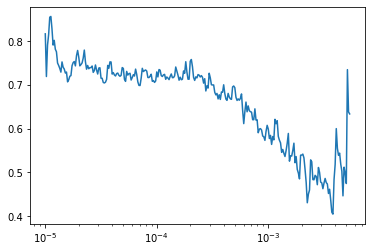

In [0]:
learner.lr_finder(bs=64, lr_range=(1e-5, 1e-1))

In [34]:
learner.train(epochs=2, bs=64, grad_clip=(0.7, 4))

06/11/2020 08:31:56 AM INFO : Epoch : 1, batch : 88, train_loss = 0.6530, val_loss = 0.6453, val_accuracy : 0.732, time = 15s
06/11/2020 08:32:10 AM INFO : Epoch : 1, batch : 176, train_loss = 0.4248, val_loss = 0.5066, val_accuracy : 0.770, time = 29s
06/11/2020 08:32:25 AM INFO : Epoch : 1, batch : 264, train_loss = 0.3774, val_loss = 0.3134, val_accuracy : 0.865, time = 44s
06/11/2020 08:32:39 AM INFO : Epoch : 1, batch : 352, train_loss = 0.3536, val_loss = 0.3129, val_accuracy : 0.876, time = 59s
06/11/2020 08:32:54 AM INFO : Epoch : 2, batch : 88, train_loss = 0.3627, val_loss = 0.7520, val_accuracy : 0.708, time = 73s
06/11/2020 08:33:09 AM INFO : Epoch : 2, batch : 176, train_loss = 0.3558, val_loss = 0.3124, val_accuracy : 0.870, time = 88s
06/11/2020 08:33:23 AM INFO : Epoch : 2, batch : 264, train_loss = 0.3689, val_loss = 0.3785, val_accuracy : 0.815, time = 102s
06/11/2020 08:33:38 AM INFO : Epoch : 2, batch : 352, train_loss = 0.3152, val_loss = 0.3019, val_accuracy : 0.8

In [35]:
model.embedding.weight.requires_grad_(True);
learner.train(epochs=8, bs=64, grad_clip=(0.7, 4))

06/11/2020 08:33:54 AM INFO : Epoch : 1, batch : 88, train_loss = 0.3284, val_loss = 0.2815, val_accuracy : 0.888, time = 16s
06/11/2020 08:34:10 AM INFO : Epoch : 1, batch : 176, train_loss = 0.3095, val_loss = 0.3539, val_accuracy : 0.857, time = 31s
06/11/2020 08:34:25 AM INFO : Epoch : 1, batch : 264, train_loss = 0.2998, val_loss = 0.2729, val_accuracy : 0.882, time = 46s
06/11/2020 08:34:41 AM INFO : Epoch : 1, batch : 352, train_loss = 0.2943, val_loss = 0.2587, val_accuracy : 0.894, time = 62s
06/11/2020 08:34:56 AM INFO : Epoch : 2, batch : 88, train_loss = 0.2786, val_loss = 0.3045, val_accuracy : 0.872, time = 77s
06/11/2020 08:35:11 AM INFO : Epoch : 2, batch : 176, train_loss = 0.2754, val_loss = 0.2570, val_accuracy : 0.898, time = 92s
06/11/2020 08:35:27 AM INFO : Epoch : 2, batch : 264, train_loss = 0.2777, val_loss = 0.2685, val_accuracy : 0.888, time = 108s
06/11/2020 08:35:42 AM INFO : Epoch : 2, batch : 352, train_loss = 0.2604, val_loss = 0.2431, val_accuracy : 0.9

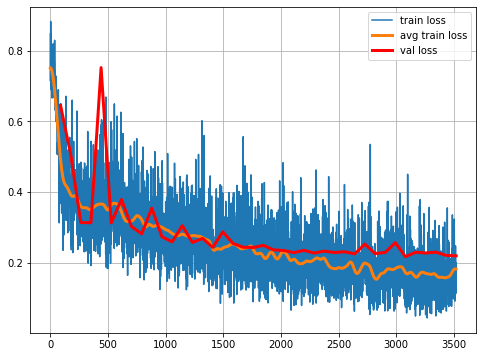

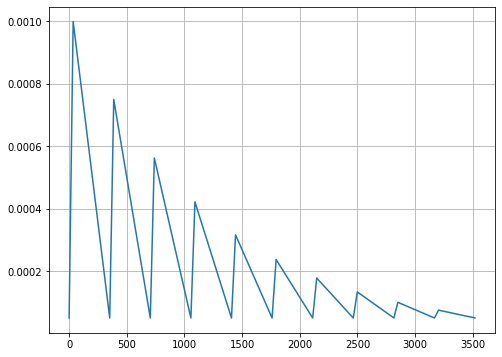

In [36]:
learner.recorder.plot_losses(show_lr=True)

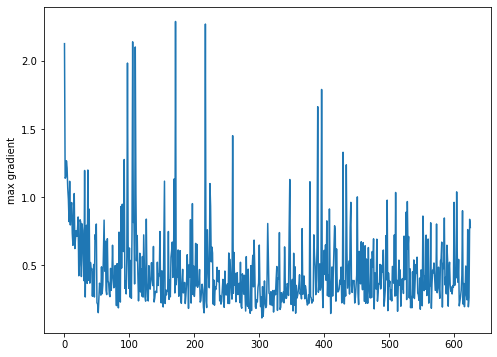

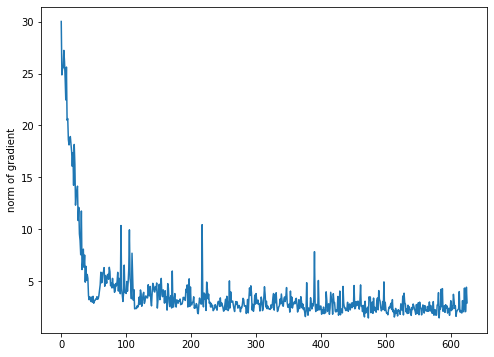

In [0]:
learner.recorder.plot_grads()

In [37]:
print('Test loss : {:.5f}, test accuracy : {:.03f}'.format(*validate(test_dataset, loss_fn, model, 64)))

Test loss : 0.21390, test accuracy : 0.915


In [0]:
if not os.path.exists('models'):
    os.makedirs('models')
torch.save(model.state_dict(), 'models/model_CNN_deep.pt')

In [141]:
# Load model
model = DCNN(emb_weights.clone(), 64, (0.4, 0.1, 0.4)).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
model.load_state_dict(torch.load('models/model_CNN_deep.pt', map_location=device))

<All keys matched successfully>

In [185]:
# Create an iterator over a test set
iterator = iter(Iterator(test_dataset, 1, shuffle=True, device=device))
model.eval();

hook_b = Hook(model.stack[-1], forward=False)
hook_f = Hook(model.stack[-1])

In [221]:
# Next batch
batch = next(iterator)

In [222]:
# Create heatmap
output = model(batch.review)
print('Label : {}'.format('positive' if batch.label.item() else 'negative'))
print('Prediction : {}'.format('positive' if output.argmax().item() else 'negative'))

if output.argmax().item():
    output[0][1].backward()
else:
    output[0][0].backward()

word_list = [test_dataset.fields['review'].vocab.itos[index] for index in batch.review[0].squeeze(0).tolist()]

map_weights = hook_b.input[0].mean(dim=-1)
grad_cam_map = nn.functional.relu(torch.bmm(map_weights.unsqueeze(0), hook_f.output))
upsampled_grad_cam_map = nn.functional.upsample(grad_cam_map, batch.review[1].item()).squeeze()
max_value = upsampled_grad_cam_map.max().item()
weights = (upsampled_grad_cam_map / max_value).tolist()

HTML(weighted_colour(word_list, weights))

Label : negative
Prediction : negative
